# Calls Only Implementation



/tmp/ipython-input-1158448721.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pdf, K_grid)
/tmp/ipython-input-1158448721.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_q = np.trapz(K * pdf, K)
/tmp/ipython-input-1158448721.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pdfp, Kp)
/tmp/ipython-input-1158448721.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pdf, K_grid)
/tmp/ipython-input-1158448721.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_q = np

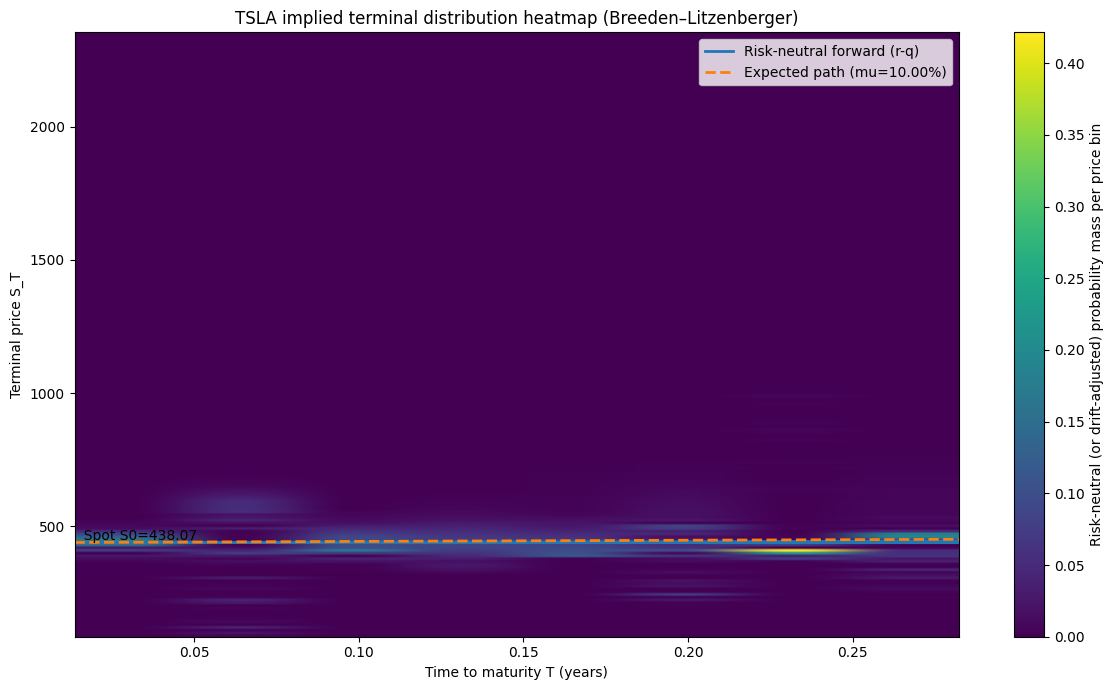

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from datetime import datetime, timezone

# -----------------------------
# User inputs
# -----------------------------
TICKER = "TSLA"          # any equity ticker supported by yfinance
MAX_EXPIRIES = 8         # how many maturities to use (closest first)
MIN_OI = 50              # filter illiquid strikes by open interest
MIN_STRIKES = 20         # minimum strikes required per maturity
SPLINE_S = 1e-3          # smoothing strength for spline on call(K)
GRID_POINTS_Y = 220      # terminal price grid resolution for heatmap
GRID_POINTS_T = None     # keep maturities discrete; set to int to interpolate in time
MU_DRIFT = 0.10          # "expected drift" (annualized, cont-comp), set None to keep risk-neutral
R_RF = 0.04              # risk-free (annualized, cont-comp)
Q_DIV = 0.00             # dividend yield (annualized, cont-comp) - set if desired

# -----------------------------
# Helpers
# -----------------------------
def yearfrac(dt0, dt1):
    # ACT/365
    return (dt1 - dt0).days / 365.0

def get_mid_price(df):
    # Prefer mid of bid/ask; fall back to lastPrice
    bid = df.get("bid", np.nan)
    ask = df.get("ask", np.nan)
    lastp = df.get("lastPrice", np.nan)
    mid = (bid + ask) / 2.0
    # if bid/ask missing or zero, use lastPrice
    mid = np.where(np.isfinite(mid) & (mid > 0), mid, lastp)
    return mid.astype(float)

def breeden_litzenberger_pdf(strikes, calls, T, r, spline_s):
    """
    Fit a smoothing spline C(K) then compute second derivative w.r.t. strike:
      f_Q(K,T) = exp(rT) * d2C/dK2
    Returns K grid, pdf on that grid.
    """
    strikes = np.asarray(strikes, dtype=float)
    calls = np.asarray(calls, dtype=float)

    # Need strictly increasing strikes
    order = np.argsort(strikes)
    strikes, calls = strikes[order], calls[order]

    # Fit smoothing spline to call prices vs strike
    # s controls smoothing. If you get negative densities, increase s a bit.
    spl = UnivariateSpline(strikes, calls, s=spline_s * len(strikes), k=3)

    K_grid = strikes
    d2C = spl.derivative(n=2)(K_grid)

    # Breeden–Litzenberger
    pdf = np.exp(r * T) * d2C

    # Clean up numerical artifacts
    pdf = np.maximum(pdf, 0.0)

    # Normalize to integrate to ~1 across available strike range
    area = np.trapz(pdf, K_grid)
    if area > 0:
        pdf = pdf / area

    return K_grid, pdf

def recenter_pdf_to_target_mean(K, pdf, target_mean):
    """
    "Factor in expected drift" by scaling terminal prices so that E[S_T] = target_mean.
    This is a simple mean-matching transform:
      S'_T = a * S_T, where a = target_mean / E_Q[S_T]
    Then the pdf transforms as:
      f'(s') = (1/a) f(s'/a)
    """
    mean_q = np.trapz(K * pdf, K)
    if mean_q <= 0:
        return K, pdf

    a = target_mean / mean_q
    Kp = K * a
    pdfp = pdf / a  # Jacobian

    # Re-normalize (in case of truncation at strike boundaries)
    area = np.trapz(pdfp, Kp)
    if area > 0:
        pdfp = pdfp / area

    return Kp, pdfp

# -----------------------------
# Pull data
# -----------------------------
tk = yf.Ticker(TICKER)
hist = tk.history(period="1y", interval="1d", auto_adjust=True)
if hist.empty:
    raise RuntimeError("No price history returned. Try a different ticker or interval.")

S0 = float(hist["Close"].iloc[-1])

# Get option expiries
expiries = tk.options
if not expiries:
    raise RuntimeError("No options expiries found for this ticker.")

expiries = expiries[:MAX_EXPIRIES]

now = datetime.now(timezone.utc).date()

maturity_data = []

for exp in expiries:
    exp_date = pd.to_datetime(exp).date()
    T = yearfrac(now, exp_date)
    if T <= 0:
        continue

    chain = tk.option_chain(exp)
    calls_df = chain.calls.copy()

    # Liquidity filter
    if "openInterest" in calls_df.columns:
        calls_df = calls_df[(calls_df["openInterest"].fillna(0) >= MIN_OI)]
    calls_df = calls_df.dropna(subset=["strike"])
    if len(calls_df) < MIN_STRIKES:
        continue

    strikes = calls_df["strike"].astype(float).values
    mids = get_mid_price(calls_df)
    mids = np.asarray(mids, dtype=float)

    # Remove junk
    mask = np.isfinite(strikes) & np.isfinite(mids) & (mids > 0)
    strikes, mids = strikes[mask], mids[mask]
    if len(strikes) < MIN_STRIKES:
        continue

    # Compute risk-neutral pdf on strike grid
    K_grid, pdf_q = breeden_litzenberger_pdf(
        strikes=strikes,
        calls=mids,
        T=T,
        r=R_RF,
        spline_s=SPLINE_S
    )

    # Optional drift adjustment
    if MU_DRIFT is not None:
        target_mean = S0 * np.exp(MU_DRIFT * T)
        K_adj, pdf_adj = recenter_pdf_to_target_mean(K_grid, pdf_q, target_mean)
    else:
        K_adj, pdf_adj = K_grid, pdf_q

    maturity_data.append({
        "expiry": exp_date,
        "T": T,
        "K": K_adj,
        "pdf": pdf_adj,
        "forward_rn": S0 * np.exp((R_RF - Q_DIV) * T),
        "expected_mu": S0 * np.exp((MU_DRIFT if MU_DRIFT is not None else (R_RF - Q_DIV)) * T),
    })

if not maturity_data:
    raise RuntimeError("No maturities passed filters. Lower MIN_OI or MIN_STRIKES.")

# -----------------------------
# Build common terminal price grid + heatmap matrix
# -----------------------------
# Define y-grid covering all maturities
K_all = np.concatenate([d["K"] for d in maturity_data])
K_min, K_max = np.percentile(K_all, 1), np.percentile(K_all, 99)
K_min = max(0.01, K_min)
K_grid_common = np.linspace(K_min, K_max, GRID_POINTS_Y)

Ts = np.array([d["T"] for d in maturity_data])
orderT = np.argsort(Ts)
maturity_data = [maturity_data[i] for i in orderT]
Ts = np.array([d["T"] for d in maturity_data])

# Interpolate each maturity pdf onto common K grid
H = np.zeros((len(K_grid_common), len(maturity_data)))
for j, d in enumerate(maturity_data):
    K, pdf = d["K"], d["pdf"]
    # interp requires increasing
    idx = np.argsort(K)
    K, pdf = K[idx], pdf[idx]
    H[:, j] = np.interp(K_grid_common, K, pdf, left=0.0, right=0.0)

# Convert densities into comparable color scale: probability mass per price-bin
# (density * dK) is easier to interpret
dK = (K_grid_common[-1] - K_grid_common[0]) / (len(K_grid_common) - 1)
H_mass = H * dK

# -----------------------------
# Plot heatmap + overlay
# -----------------------------
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()

# Heatmap: y = terminal price, x = maturity index (or T)
# Use extent so axis is in year fractions
extent = [Ts.min(), Ts.max(), K_grid_common[0], K_grid_common[-1]]

im = ax.imshow(
    H_mass,
    origin="lower",
    aspect="auto",
    extent=extent
)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Risk-neutral (or drift-adjusted) probability mass per price bin")

# Overlay: spot history mapped to "time-to-maturity axis"
# This is not the same dimension physically, but overlay is still useful visually.
# We'll instead overlay spot as a horizontal line at S0 and forward/expected curves vs T.
ax.axhline(S0, linewidth=1.5)
ax.text(Ts.min(), S0, f"  Spot S0={S0:.2f}", va="bottom")

forwards = np.array([d["forward_rn"] for d in maturity_data])
ax.plot(Ts, forwards, linewidth=2.0, label="Risk-neutral forward (r-q)")

expecteds = np.array([d["expected_mu"] for d in maturity_data])
if MU_DRIFT is not None:
    ax.plot(Ts, expecteds, linewidth=2.0, linestyle="--", label=f"Expected path (mu={MU_DRIFT:.2%})")

ax.set_title(f"{TICKER} implied terminal distribution heatmap (Breeden–Litzenberger)")
ax.set_xlabel("Time to maturity T (years)")
ax.set_ylabel("Terminal price S_T")

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


# Calls and Puts Implementation

Puts can be a little noisier. Include in Spline function anyway...

/tmp/ipython-input-1111060750.py:161: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pdf, K_dense)
/tmp/ipython-input-1111060750.py:161: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pdf, K_dense)
/tmp/ipython-input-1111060750.py:161: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pdf, K_dense)
/tmp/ipython-input-1111060750.py:161: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pdf, K_dense)
/tmp/ipython-input-1111060750.py:161: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  

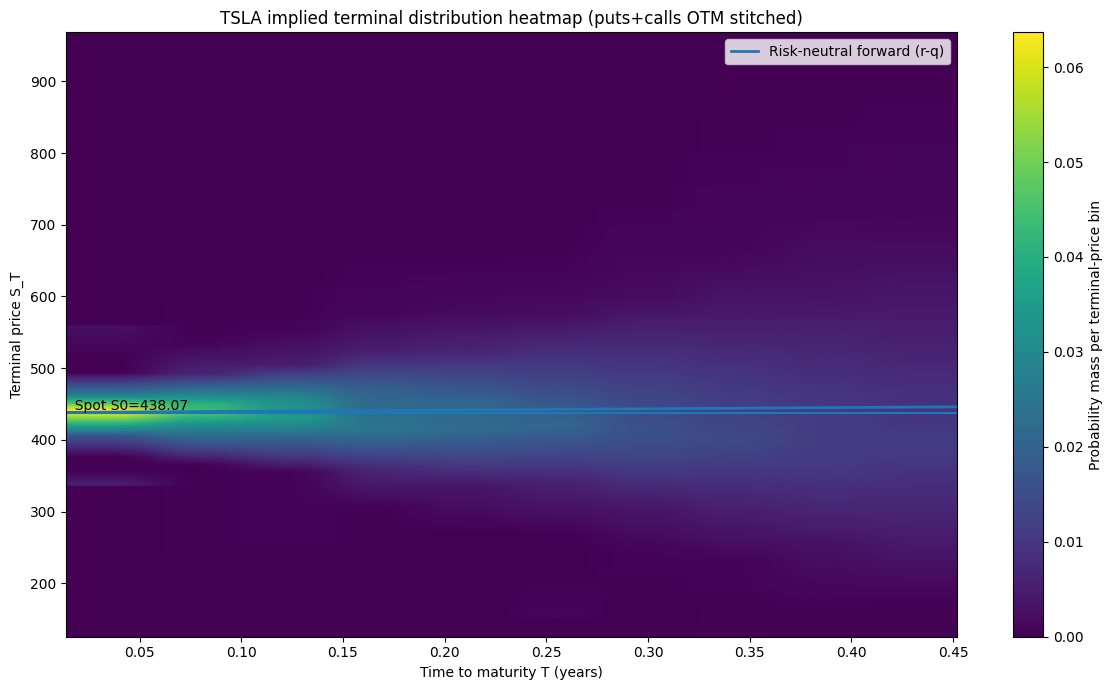

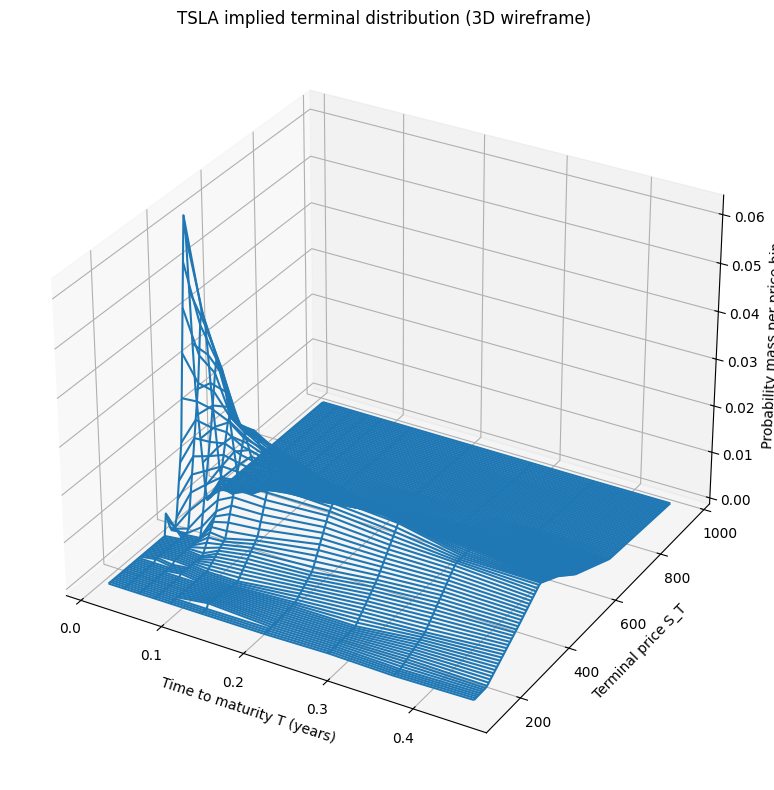

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from datetime import datetime, timezone
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# ============================================================
# CONFIG
# ============================================================
TICKER = "TSLA"
MAX_EXPIRIES = 10

# Carry inputs (continuous comp). q matters for dividend-paying names.
R_RF = 0.04
Q_DIV = 0.00

# Optional: mean-shift overlay (NOT implied by options; assumption)
MU_DRIFT = None  # e.g., 0.10 or None

# Quote quality / liquidity filters
MIN_OI = 50
MAX_REL_SPREAD = 0.25     # drop quotes with spread > 25% of mid (where bid/ask exist)
MIN_STRIKES = 30          # minimum strikes after stitching/filters

# Stitching rule parameters
BLEND_BAND = 0.02         # +/- 2% around forward to blend puts->calls and avoid a seam

# Spline + grids
SPLINE_S = 3e-3           # smoothing; increase to reduce spiky density
KGRID_POINTS = 700        # dense strike grid per expiry for stable derivatives
YGRID_POINTS = 260        # terminal price axis for heatmap


# ============================================================
# HELPERS
# ============================================================
def yearfrac(dt0, dt1):
    """ACT/365 year fraction using dates."""
    return (dt1 - dt0).days / 365.0


def mid_and_rel_spread(df: pd.DataFrame):
    """
    Returns mid and relative spread arrays.
    Mid = (bid+ask)/2 if available else lastPrice.
    rel_spread = (ask-bid)/mid if bid/ask available.
    """
    bid = df.get("bid", np.nan).astype(float)
    ask = df.get("ask", np.nan).astype(float)
    lastp = df.get("lastPrice", np.nan).astype(float)

    mid = (bid + ask) / 2.0
    mid = np.where(np.isfinite(mid) & (mid > 0), mid, lastp)

    spread = (ask - bid)
    spread = np.where(np.isfinite(spread) & (spread >= 0), spread, np.nan)
    rel = np.where(mid > 0, spread / mid, np.nan)

    return mid.astype(float), rel.astype(float)


def clean_chain(df: pd.DataFrame, min_oi: int, max_rel_spread: float):
    """
    Liquidity + quality filtering.
    - openInterest >= min_oi (if column exists)
    - mid > 0
    - rel_spread <= max_rel_spread when rel_spread is known
    """
    out = df.copy().dropna(subset=["strike"])

    if "openInterest" in out.columns:
        out = out[out["openInterest"].fillna(0) >= min_oi]

    mid, rel = mid_and_rel_spread(out)
    out["mid"] = mid
    out["rel_spread"] = rel

    out = out[np.isfinite(out["mid"]) & (out["mid"] > 0)]
    out = out[(out["rel_spread"].isna()) | (out["rel_spread"] <= max_rel_spread)]

    return out[["strike", "mid", "rel_spread"]].copy()


def parity_put_to_call(P, S0, K, r, q, T):
    """Put-call parity: C = P + S e^{-qT} - K e^{-rT}"""
    return P + S0 * np.exp(-q * T) - K * np.exp(-r * T)


def build_otm_stitched_call_curve(calls_df, puts_df, S0, r, q, T,
                                  min_oi=50, max_rel_spread=0.25, blend_band=0.02):
    """
    YOUR RULE:
      - If strike is "high" (K >= forward F): use CALL mid
      - If strike is "low"  (K <  forward F): use PUT mid converted to call via parity
    Then blend in a band around F to avoid a seam that creates artificial curvature.

    Returns: K_sorted, C_stitched_sorted, F
    """
    F = S0 * np.exp((r - q) * T)

    c = clean_chain(calls_df, min_oi=min_oi, max_rel_spread=max_rel_spread).rename(columns={"mid": "C_mid"})
    p = clean_chain(puts_df,  min_oi=min_oi, max_rel_spread=max_rel_spread).rename(columns={"mid": "P_mid"})

    m = pd.merge(c, p, on="strike", how="outer")
    m["strike"] = m["strike"].astype(float)

    K = m["strike"].values
    C_mid = m.get("C_mid", pd.Series(np.nan, index=m.index)).values
    P_mid = m.get("P_mid", pd.Series(np.nan, index=m.index)).values
    C_from_put = np.where(np.isfinite(P_mid), parity_put_to_call(P_mid, S0, K, r, q, T), np.nan)

    C_stitched = np.full_like(K, np.nan, dtype=float)

    # Stitch: low K -> puts (converted), high K -> calls
    use_call = (K >= F)
    use_put = (K < F)
    C_stitched[use_call] = C_mid[use_call]
    C_stitched[use_put] = C_from_put[use_put]

    # Blend near forward to avoid a kink (only where both exist)
    if blend_band and blend_band > 0:
        lo = F * (1 - blend_band)
        hi = F * (1 + blend_band)
        band = (K >= lo) & (K <= hi)

        ok = band & np.isfinite(C_mid) & np.isfinite(C_from_put)
        if np.any(ok):
            w = (K[ok] - lo) / (hi - lo)  # 0 at lo, 1 at hi
            C_stitched[ok] = (1 - w) * C_from_put[ok] + w * C_mid[ok]

    out = pd.DataFrame({"K": K, "C": C_stitched}).dropna()
    out = out.sort_values("K").groupby("K", as_index=False)["C"].median()

    return out["K"].values, out["C"].values, F


def breeden_litzenberger_pdf_from_calls(K, C, T, r, spline_s, kgrid_points):
    """
    Fit spline to C(K), evaluate on dense K-grid, compute:
      f_Q(K) = exp(rT) * d2C/dK2
    Return dense K-grid and normalized pdf.
    """
    K = np.asarray(K, dtype=float)
    C = np.asarray(C, dtype=float)
    order = np.argsort(K)
    K, C = K[order], C[order]

    # Dense grid across available strikes
    K_dense = np.linspace(K.min(), K.max(), kgrid_points)

    # Smooth spline (prices -> second derivative is noise-sensitive)
    spl = UnivariateSpline(K, C, s=spline_s * len(K), k=3)
    d2C = spl.derivative(n=2)(K_dense)

    pdf = np.exp(r * T) * d2C
    pdf = np.maximum(pdf, 0.0)

    area = np.trapz(pdf, K_dense)
    if area > 0:
        pdf /= area

    return K_dense, pdf


def mean_shift_pdf(K, pdf, target_mean):
    """
    Simple mean-matching transform: S' = a S, a = target_mean / E[S]
    f'(s') = (1/a) f(s'/a)
    """
    mean = np.trapz(K * pdf, K)
    if not np.isfinite(mean) or mean <= 0:
        return K, pdf

    a = target_mean / mean
    Kp = K * a
    pdfp = pdf / a

    area = np.trapz(pdfp, Kp)
    if area > 0:
        pdfp /= area

    return Kp, pdfp


# ============================================================
# MAIN
# ============================================================
def main():
    tk = yf.Ticker(TICKER)

    # Price history (for spot overlay)
    hist = tk.history(period="1y", interval="1d", auto_adjust=True)
    if hist.empty:
        raise RuntimeError("No price history returned. Try a different ticker.")

    S0 = float(hist["Close"].iloc[-1])
    today = datetime.now(timezone.utc).date()

    expiries = tk.options
    if not expiries:
        raise RuntimeError("No option expiries found for this ticker.")
    expiries = expiries[:MAX_EXPIRIES]

    maturity_data = []

    for exp in expiries:
        exp_date = pd.to_datetime(exp).date()
        T = yearfrac(today, exp_date)
        if T <= 0:
            continue

        chain = tk.option_chain(exp)

        # Stitch OTM side into a single call curve C(K)
        K, C, F = build_otm_stitched_call_curve(
            calls_df=chain.calls,
            puts_df=chain.puts,
            S0=S0,
            r=R_RF,
            q=Q_DIV,
            T=T,
            min_oi=MIN_OI,
            max_rel_spread=MAX_REL_SPREAD,
            blend_band=BLEND_BAND
        )

        if len(K) < MIN_STRIKES:
            continue

        # Risk-neutral pdf from second derivative wrt strike
        K_dense, pdf_q = breeden_litzenberger_pdf_from_calls(
            K=K, C=C, T=T, r=R_RF, spline_s=SPLINE_S, kgrid_points=KGRID_POINTS
        )

        # Optional mean shift to MU_DRIFT (assumption)
        if MU_DRIFT is not None:
            target_mean = S0 * np.exp(MU_DRIFT * T)
            K_use, pdf_use = mean_shift_pdf(K_dense, pdf_q, target_mean)
        else:
            K_use, pdf_use = K_dense, pdf_q

        maturity_data.append({
            "expiry": exp_date,
            "T": T,
            "K": K_use,
            "pdf": pdf_use,
            "forward_rn": S0 * np.exp((R_RF - Q_DIV) * T),
            "expected_mu": S0 * np.exp(((MU_DRIFT if MU_DRIFT is not None else (R_RF - Q_DIV)) * T)),
            "F_boundary": F
        })

    if not maturity_data:
        raise RuntimeError(
            "No maturities passed filters. Lower MIN_OI / MAX_REL_SPREAD or increase MAX_EXPIRIES."
        )

    maturity_data = sorted(maturity_data, key=lambda d: d["T"])
    Ts = np.array([d["T"] for d in maturity_data], dtype=float)

    # Common terminal-price grid for heatmap
    K_all = np.concatenate([d["K"] for d in maturity_data])
    k_lo, k_hi = np.percentile(K_all, 1), np.percentile(K_all, 99)
    k_lo = max(0.01, k_lo)
    K_common = np.linspace(k_lo, k_hi, YGRID_POINTS)

    # Heatmap matrix: convert density to probability mass per bin (density * dK)
    H = np.zeros((len(K_common), len(maturity_data)), dtype=float)
    for j, d in enumerate(maturity_data):
        K = d["K"]
        pdf = d["pdf"]
        idx = np.argsort(K)
        K, pdf = K[idx], pdf[idx]
        H[:, j] = np.interp(K_common, K, pdf, left=0.0, right=0.0)

    dK = (K_common[-1] - K_common[0]) / (len(K_common) - 1)
    H_mass = H * dK  # easier to interpret than raw density

    # ============================================================
    # 2D HEATMAP
    # ============================================================
    fig = plt.figure(figsize=(12, 7))
    ax = plt.gca()

    extent = [Ts.min(), Ts.max(), K_common[0], K_common[-1]]
    im = ax.imshow(H_mass, origin="lower", aspect="auto", extent=extent)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Probability mass per terminal-price bin")

    # Overlays
    ax.axhline(S0, linewidth=1.5)
    ax.text(Ts.min(), S0, f"  Spot S0={S0:.2f}", va="bottom")

    forwards = np.array([d["forward_rn"] for d in maturity_data], dtype=float)
    ax.plot(Ts, forwards, linewidth=2.0, label="Risk-neutral forward (r-q)")

    if MU_DRIFT is not None:
        expecteds = np.array([d["expected_mu"] for d in maturity_data], dtype=float)
        ax.plot(Ts, expecteds, linewidth=2.0, linestyle="--",
                label=f"Mean-shift path (mu={MU_DRIFT:.2%})")

    ax.set_title(f"{TICKER} implied terminal distribution heatmap (puts+calls OTM stitched)")
    ax.set_xlabel("Time to maturity T (years)")
    ax.set_ylabel("Terminal price S_T")
    ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # ============================================================
    # 3D WIREFRAME (your requested option #2)
    # ============================================================
    T_grid, K_grid = np.meshgrid(Ts, K_common)  # (len(K_common), len(Ts))

    fig3d = plt.figure(figsize=(13, 8))
    ax3d = fig3d.add_subplot(111, projection="3d")

    # Downsample for readability/performance
    ds_T = max(1, len(Ts) // 30)
    ds_K = max(1, len(K_common) // 120)

    ax3d.plot_wireframe(
        T_grid[::ds_K, ::ds_T],
        K_grid[::ds_K, ::ds_T],
        H_mass[::ds_K, ::ds_T],
        rstride=1,
        cstride=1
    )

    ax3d.set_title(f"{TICKER} implied terminal distribution (3D wireframe)")
    ax3d.set_xlabel("Time to maturity T (years)")
    ax3d.set_ylabel("Terminal price S_T")
    ax3d.set_zlabel("Probability mass per price bin")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
